# Part 2 : Would players be better now ?

## Using the new structure, would players perform better in this Wikipedia version? 

for unfinished paths, check if new links would have appeared on articles visited during the games of 2007
Does one of the new links redirect to the target?
If not, is the shortest path to the target from the visited articles shorter than in 2007?
for finished paths, would the players win sooner in the current version? -> see if the end goal appears sooner in the 2024 hyperlinks 


### Import

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import networkx as nx

from scipy import stats

In [2]:
PATH_2007 = os.path.join('data', '2007')
PATH_2024 = os.path.join('data', '2024')

### Study of the players paths

In [ ]:
links2007 = pd.read_csv(os.path.join(PATH_2007, 'links.tsv'), sep='\t', comment='#', names=['linkSource', 'linkTarget'])
links2024 = pd.read_csv(os.path.join(PATH_2024, 'links2024.csv'))
links2024 = links2024.drop_duplicates().reset_index(drop=True)

#### Paths unfinished

In [4]:
path_unfinished = pd.read_csv(os.path.join(PATH_2007, 'paths_unfinished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], usecols=['hashedIpAddress', 'durationInSec', 'path', 'target', 'type'])

Let's check if a path unfinished could have been finished in 2007 (if the player just miss the target in his path) and compare it to wikipedia 2024 links structure to see if the player would have been able to finish the game in 2024 shorter than in 2007.


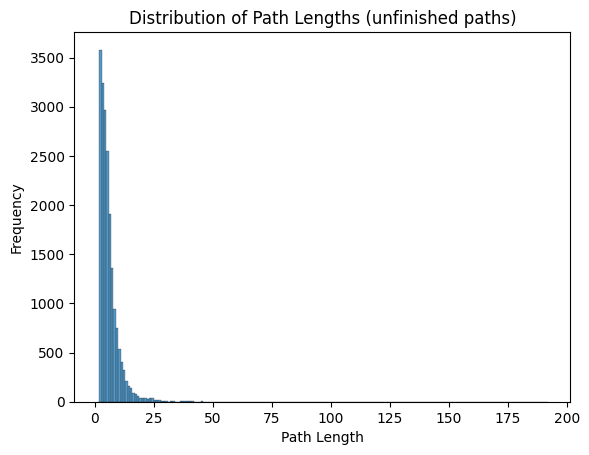

In [5]:
# get path length
path_unfinished['path_length'] = path_unfinished['path'].apply(lambda x: len([i for i in x.split(';') if i != '<']))

# remove path with only one element -> not considered as an attempt
path_unfinished = path_unfinished[path_unfinished['path_length'] > 1]

# plot distribution
sns.histplot(path_unfinished['path_length'], bins=range(1, max(path_unfinished['path_length'])+1), kde=False)
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.title('Distribution of Path Lengths (unfinished paths)')
plt.show()

In [6]:
path_unfinished.describe()['path_length']

count    19661.000000
mean         5.654545
std          4.708857
min          2.000000
25%          3.000000
50%          5.000000
75%          7.000000
max        192.000000
Name: path_length, dtype: float64

In [ ]:
def fix_path(path):
    """
    Fix the path by removing the last element if it is '<'
    """
    path_elements = path.split(';')
    result_stack = []

    for element in path_elements:
        if element == '<':
            if result_stack:  # Remove the last element only if the stack is not empty
                result_stack.pop()
        else:
            result_stack.append(element)

    return result_stack


def check_if_link_exists(row, links):
    """
    Check if in the path of the row, there is a faster way to reach the target
    Also, check if the path is valid
    """
    path_list = fix_path(row['path'])
    # Convert list to a set for quick lookup and calculate target links
    path_set = set(path_list)
    target = row['target']
    
    # Filter links2024 to get only relevant links with target linkSource in path
    last_links = set(links.loc[links['linkTarget'] == target, 'linkSource'])
    intersecting_links = path_set.intersection(last_links)
    
    if intersecting_links:
        # Verify that each path[i+1] exists in the linkTarget of path[i]
        for i in range(len(path_list) - 1):
            current_node = path_list[i]
            next_node = path_list[i + 1]
            # Check if next_node is in linkTarget of current_node in links2024
            if not ((links['linkSource'] == current_node) & (links['linkTarget'] == next_node)).any():
                return None, -1  # Return None, -1 if the link is invalid
        
        # Find the index of the first occurrence in path_list
        index = next((i for i, link in enumerate(path_list) if link in intersecting_links), None)
        return path_list[index], len(path_list) - index - 1
    else:
        return path_list[-1], 0

In [ ]:
# # create a dafaframe with columns 'path', 'target', 'final_link2007', 'final_link2024', 'distance2007', 'distance2024'
# df_unfinished = []

# for i, data in tqdm(path_unfinished.iterrows(), total=len(path_unfinished), desc='Processing data'):
#     output_link, distance = check_if_link_exists(data, links2007)
#     output_link2, distance2 = check_if_link_exists(data, links2024)

#     # add the data to the output dataframe
#     df_unfinished.append({'path': data['path'], 'target': data['target'], 'final_link2007': output_link, 'final_link2024': output_link2, 'distance2007': distance, 'distance2024': distance2})
    
# df_unfinished = pd.DataFrame(df_unfinished)

# save df_unfinished to a csv file
# df_unfinished.to_csv(os.path.join(PATH_2007, 'comparison_unfinished_to_2024.csv'), index=False)

Processing data: 100%|██████████| 19661/19661 [11:12<00:00, 29.22it/s]


In [7]:
df_unfinished = pd.read_csv(os.path.join(PATH_2007, 'comparison_unfinished_to_2024.csv'))

In [ ]:
# testpath = path_unfinished.iloc[2232].path
# testpath = fix_path(testpath)

# for i in range(len(testpath) - 1):
#     output = links2007[ (links2007.linkSource == testpath[i]) & (links2007.linkTarget == testpath[i+1])]
#     if output.empty:
#         print(f'Link {testpath[i]} -> {testpath[i+1]} does not exist in links2007')

Link Finland -> %C3%85land does not exist in links2007


Find a way to have a good reprensentation of this (Interactive graph representation ?):

In [8]:
print("==== Path possible ? ====")

print(f"Path won't change between 2007 and 2024 : {len(df_unfinished[(df_unfinished.distance2007 == 0) & (df_unfinished.distance2024 == 0)])}")
print(f"Path impossible to do in 2024 but possible in 2007 : {len(df_unfinished[(df_unfinished.distance2007 >= 0) & (df_unfinished.distance2024 == -1)])}")
print(f"Path still possible in 2024 : {len(df_unfinished[(df_unfinished.distance2007 >= 0) & (df_unfinished.distance2024 >= 0)])}")

print()
print("==== Path faster or slower in 2024 ? ====")
print(f"Path faster in 2024 than 2007: {len(df_unfinished[df_unfinished.distance2007 < df_unfinished.distance2024])}")
print(f"Path slower in 2024 than 2007: {len(df_unfinished[(df_unfinished.distance2007 > df_unfinished.distance2024) & (df_unfinished.distance2024 >= 0)])}")

==== Path possible ? ====
Path won't change between 2007 and 2024 : 14537
Path impossible to do in 2024 but possible in 2007 : 4324
Path still possible in 2024 : 15335

==== Path faster or slower in 2024 ? ====
Path faster in 2024 than 2007: 423
Path slower in 2024 than 2007: 305


#### Paths finished

In [10]:
path_finished = pd.read_csv(os.path.join(PATH_2007, 'paths_finished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
path_finished['target'] = path_finished['path'].apply(lambda x: x.split(';')[-1])
path_finished['path_length'] = path_finished['path'].apply(lambda x: len([i for i in x.split(';') if i != '<']))

In [11]:
stats.pearsonr(path_finished.dropna(subset=['rating'])['path_length'], path_finished.dropna(subset=['rating'])['rating'])

PearsonRResult(statistic=0.4078773989988144, pvalue=0.0)

In [12]:
stats.spearmanr(path_finished.dropna(subset=['rating'])['path_length'], path_finished.dropna(subset=['rating'])['rating'])

SignificanceResult(statistic=0.5642040768809875, pvalue=0.0)

Significant correlation between the path length and rating of the player.

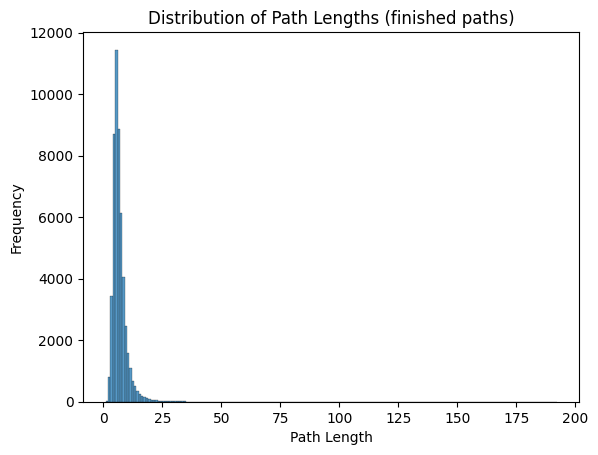

In [13]:
sns.histplot(path_finished['path_length'], bins=range(1, max(path_unfinished['path_length'])+1), kde=False)
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.title('Distribution of Path Lengths (finished paths)')
plt.show()

In [14]:
def check_if_link_exists_finished(row, links):
    path_list = fix_path(row['path'])
    if len(path_list) > 1:
        target = row['target']
        path_list.remove(target)
        
        # Convert list to a set for quick lookup and calculate target links
        path_set = set(path_list)
        
        # Filter links2024 to get only relevant links with target linkSource in path
        last_links = set(links.loc[links['linkTarget'] == target, 'linkSource'])
        intersecting_links = path_set.intersection(last_links)
        
        if intersecting_links:
            # Verify that each path[i+1] exists in the linkTarget of path[i]
            for i in range(len(path_list) - 1):
                current_node = path_list[i]
                next_node = path_list[i + 1]
                # Check if next_node is in linkTarget of current_node in links2024
                if not ((links['linkSource'] == current_node) & (links['linkTarget'] == next_node)).any():
                    return None, -1  # Return None, -1 if the link is invalid
            
            # Find the index of the first occurrence in path_list
            index = next((i for i, link in enumerate(path_list) if link in intersecting_links), None)
            return path_list[index], len(path_list) - index - 1
        else:
            return path_list[-1], 0
    else:
        return path_list[0], 0

In [ ]:
# df_finished = []

# for i, data in tqdm(path_finished.iterrows(), total=len(path_finished), desc='Processing data'):
#     subdata = data[['path', 'target']]
#     output_link, distance = check_if_link_exists_finished(subdata, links2007)
#     output_link2, distance2 = check_if_link_exists_finished(subdata, links2024)

#     # add the data to the output dataframe
#     df_finished.append({'path': data['path'], 'target': data['target'], 'final_link2007': output_link, 'final_link2024': output_link2, 'distance2007': distance, 'distance2024': distance2})

# df_finished = pd.DataFrame(df_finished)
# df_finished.to_csv(os.path.join(PATH_2007, 'comparison_finished_to_2024.csv'), index=False)

Processing data: 100%|██████████| 45460/45460 [1:11:40<00:00, 10.57it/s]


In [15]:
df_finished = pd.read_csv(os.path.join(PATH_2007, 'comparison_finished_to_2024.csv'))

In [29]:
path_finished.iloc[8046]['path']

'United_States;Washington%2C_D.C.;Government;Corporation;Employment;Trade_union;<;Marxism;Politics;Political_philosophy;Augustine_of_Hippo;Philosophy;Mathematics;Science;Society;Culture;Language;Sound;Music;<;Gas;Phase_%28matter%29;Thermodynamics;Heat;Energy;Force;Archimedes;Isaac_Newton;Momentum;Ren%C3%A9_Descartes;Mathematical_analysis;19th_century;British_Empire;Society;Switzerland;Latin;Vulgar_Latin;9th_century;Time;Number;Measurement;Milky_Way;Sphere;Physics;Universe;Cosmic_inflation;Metric_expansion_of_space;<;<;Big_Bang;Cosmic_microwave_background_radiation;Electromagnetic_radiation;Electric_field;Electric_charge;Michael_Faraday;England;Great_Britain;United_Kingdom;France;Franks;Germany;Luxembourg;Constitutional_monarchy;United_Kingdom;<;Japan;Buddhism;Buddha;Gautama_Buddha;Nepal;India;Indonesia;Netherlands;International_Court_of_Justice;United_States;Holy_Roman_Empire;Pope;Vatican_City;Election;Citizenship;Country;Antarctica;Desert;Sand;Granite;Crystal;Glass;Biology;Biodiversit

In [38]:
testpath = path_finished.iloc[48079].path
testpath = fix_path(testpath)

for i in range(len(testpath) - 1):
    output = links2007[ (links2007.linkSource == testpath[i]) & (links2007.linkTarget == testpath[i+1])]
    if output.empty:
        print(f'Link {testpath[i]} -> {testpath[i+1]} does not exist in links2007')

Link Claude_Monet -> %C3%89douard_Manet does not exist in links2007


In [17]:
from urllib.parse import unquote
print(unquote('%C3%85land'))
print(unquote('%C3%89ire'))
print(unquote('%C3%89douard_Manet'))

Åland
Éire
Édouard_Manet


In [35]:
path_finished.iloc[48079].path

'The_Cantos;Renaissance;Leonardo_da_Vinci;Mona_Lisa;Oil_painting;Impressionism;Claude_Monet;%C3%89douard_Manet;Diego_Vel%C3%A1zquez;Francisco_Goya;Printmaking'

In [23]:
df_finished[df_finished.distance2007 == -1]

,path,target,final_link2007,final_link2024,distance2007,distance2024
4375,Euro;Finland;%C3%85land;Baltic_Sea;Atlantic_Oc...,Whale,NaN,Atlantic_Ocean,-1,0
8046,United_States;Washington%2C_D.C.;Government;Co...,English_language,NaN,NaN,-1,-1
9794,Democratic_Action_Party;Parliament_of_Malaysia...,Fruit,NaN,Florida,-1,0
17848,Finance;Money;Gold;19th_century;Impressionism;...,Drawing,NaN,NaN,-1,-1
48079,The_Cantos;Renaissance;Leonardo_da_Vinci;Mona_...,Printmaking,NaN,Oil_painting,-1,5


In [18]:
print("==== Path possible ? ====")

print(f"Path won't change between 2007 and 2024 : {len(df_finished[(df_finished.distance2007 == 0) & (df_finished.distance2024 == 0)])}")
print(f"Path impossible to do in 2024 but possible in 2007 : {len(df_finished[(df_finished.distance2007 >= 0) & (df_finished.distance2024 == -1)])}")
print(f"Path still possible in 2024 : {len(df_finished[(df_finished.distance2007 >= 0) & (df_finished.distance2024 >= 0)])}")

print()
print("==== Path faster or slower in 2024 ? ====")
print(f"Path faster in 2024 than 2007: {len(df_finished[df_finished.distance2007 < df_finished.distance2024])}")
print(f"Path slower or equal in 2024 than 2007: {len(df_finished[(df_finished.distance2007 >= df_finished.distance2024) & (df_finished.distance2024 >= 0) & (df_finished.distance2007 > 0)])}")

==== Path possible ? ====
Path won't change between 2007 and 2024 : 14020
Path impossible to do in 2024 but possible in 2007 : 32677
Path still possible in 2024 : 18636

==== Path faster or slower in 2024 ? ====
Path faster in 2024 than 2007: 2719
Path slower or equal in 2024 than 2007: 1900


In [20]:
finished_stats2024 = df_finished[df_finished.distance2024 != -1].distance2024.describe()
finished_stats2024

count    18639.000000
mean         0.294383
std          0.734087
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         27.000000
Name: distance2024, dtype: float64

In [21]:
finished_stats2007 = df_finished[df_finished.distance2007 != -1].distance2007.describe()
finished_stats2007

count    51313.000000
mean         0.286438
std          1.152318
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         79.000000
Name: distance2007, dtype: float64